# Q-Learning with Battery Example
Purpose of this notebook is to demonstrate the ability of a reinforcement learning agent based on Q-Learning to learn to control a battery.

In [1]:
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf

from energy_py import EternityVisualizer
from energy_py.agents import DQN, Q_DQN
from energy_py.envs import BatteryEnv

In [2]:
#  set random seeds for repeatability
np.random.seed(42)
tf.set_random_seed(42)

In [3]:
#  let our environment know where our state & observation data is
data_path = os.getcwd()

#  keep all of the BatteryEnv variables (episode length, efficiency etc)
#  at their defaults
env = BatteryEnv(data_path)

In [4]:
#  define a batch size, discount rate and total number of episodes 
BATCH_SIZE = 32
DISCOUNT = 0.95
EPISODES = 2000

#  in order to setup hyperparameters like epsilon decay or target net
#  update frequency, we need to let our agent know how many total steps
#  it will take in it's life
total_steps = env.episode_length * EPISODES

#  now we setup our agent
#  we pass in an object to approximate Q(s,a)
#  this object is an energy_py function approximator that uses 
#  Tensorflow to estimate expected discounted return for each action
agent = DQN(env,
            discount=DISCOUNT,
            Q=Q_DQN,
            total_steps=total_steps)

In [5]:
#  simple class to time the experiment

class Timer(object):
    def __init__(self):
        self.start_time = time.time()
        
    def calc_time(self, episode, avg_reward):
        run_time = time.time() - self.start_time
        avg_time = run_time / episode
        print('{:1.0f} episodes in {:2.1f} sec - avg {:.1f} sec per episode - avg lifetime reward {:3.3f} $/5min'.format(episode, run_time, avg_time, avg_reward))
        return run_time, avg_time

In [6]:
#  we track total steps to know when to learn and 
#  update the target net
total_step = 0
timer = Timer()

#  initialize Tensorflow machinery
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #  for loop over episodes
    for episode in range(1, EPISODES):
        #  initialize before starting episode
        done, step = False, 0
        #  reset the environment
        observation = env.reset(episode)
        
        #  a while loop to run through a single episode
        #  will terminate when the env returns done=True after a step
        while done is False:
            #  agent uses observation to select an action
            action = agent.act(sess=sess, obs=observation)
            
            #  take a step through the environment
            next_observation, reward, done, info = env.step(action)
            
            #  store the experience in the agent memory
            agent.memory.add_experience(observation, action, reward,
                                       next_observation, done,
                                       step, episode)
            
            #  the DQN agent has an initial number of steps of
            #  no learning to fill it's memory
            #  if we are beyond this we learn at each step
            if total_step > agent.initial_random:
                #  get a batch of experience
                #  this is naive experience replay (no prioritization)
                batch = agent.memory.get_random_batch(BATCH_SIZE)
                
                #  learn using the batch
                training_info = agent.learn(sess=sess, batch=batch)
                
                #  optionally update the target network
                if total_step % agent.update_target_net == 0:
                    agent.update_target_network(sess)
                    
            #  move on to the next step
            step += 1
            total_step += 1
            observation = next_observation
            
        if episode % 200 == 0:
            avg_reward = np.mean(agent.memory.rewards)
            run_time, avg_time = timer.calc_time(episode, avg_reward)
            
#  one final run of the timer
run_time, avg_time = timer.calc_time(episode, avg_reward)

200 episodes in 21.9 sec - avg 0.1 sec per episode - avg lifetime reward -0.416 $/5min
400 episodes in 1052.6 sec - avg 2.6 sec per episode - avg lifetime reward -0.262 $/5min
600 episodes in 3781.0 sec - avg 6.3 sec per episode - avg lifetime reward -0.034 $/5min
800 episodes in 8218.1 sec - avg 10.3 sec per episode - avg lifetime reward 0.203 $/5min
1000 episodes in 14287.6 sec - avg 14.3 sec per episode - avg lifetime reward 0.440 $/5min
1200 episodes in 22028.9 sec - avg 18.4 sec per episode - avg lifetime reward 0.715 $/5min
1400 episodes in 31427.0 sec - avg 22.4 sec per episode - avg lifetime reward 0.960 $/5min
1600 episodes in 42525.9 sec - avg 26.6 sec per episode - avg lifetime reward 1.153 $/5min
1800 episodes in 55290.4 sec - avg 30.7 sec per episode - avg lifetime reward 1.322 $/5min
1999 episodes in 69620.8 sec - avg 34.8 sec per episode - avg lifetime reward 1.322 $/5min


In [7]:
#  now our experiment is over, we can look at the results
#  create an object to collect data and create figures
hist = EternityVisualizer(agent, env)

#  implement the functionality of the EternityVisualizer class
agent_outputs, env_outputs = hist.output_results(save_data=False)

/home/adam/anaconda3/envs/energy_py/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [8]:
#  the Eternity Visualizer has created a number of figures from
#  the agent and environment
hist.figs_dict.keys()

dict_keys(['reward_panel', 'max_Q_acting estimates', 'old_charge', 'reward', 'scaled_targets', 'gross_rate', 'env_panel_fig', 'avg_Q_acting estimates', 'avg_scaled_target', 'done', 'unscaled_targets', 'loss', 'scaled_obs', 'losses', 'epsilon', 'Q act est', 'steps', 'train_error', 'max_scaled_target', 'episode', 'new_charge', 'net_stored', 'electricity_price'])

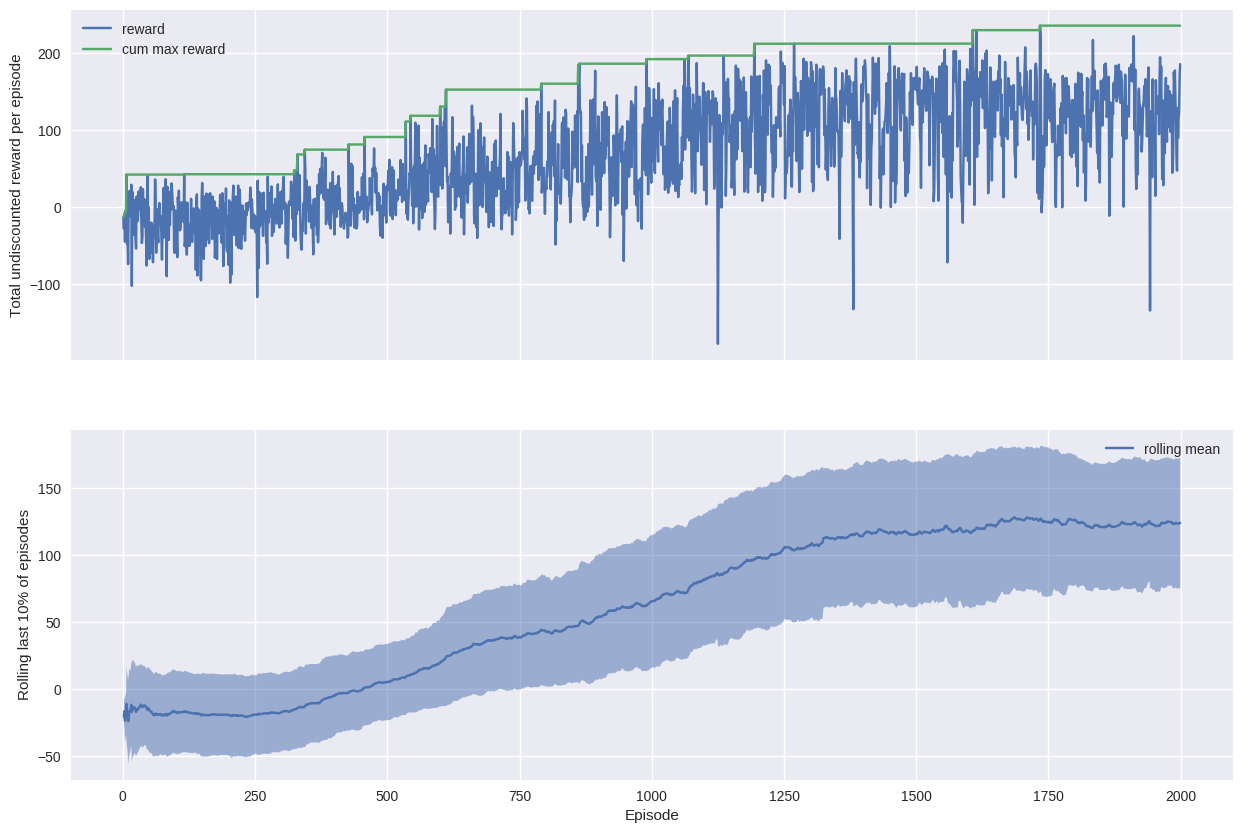

In [9]:
# jupyter magic command to get matplotlib to play nice 
%matplotlib inline  

#  the most useful figure is the reward panel, showing:
#  1 reward per episode (and max reward seen so far)
#  2 the mean total reward of the last 10% of episodes
#    shaded = the standard deviation (also last 10% of episodes)
hist.figs_dict['reward_panel']

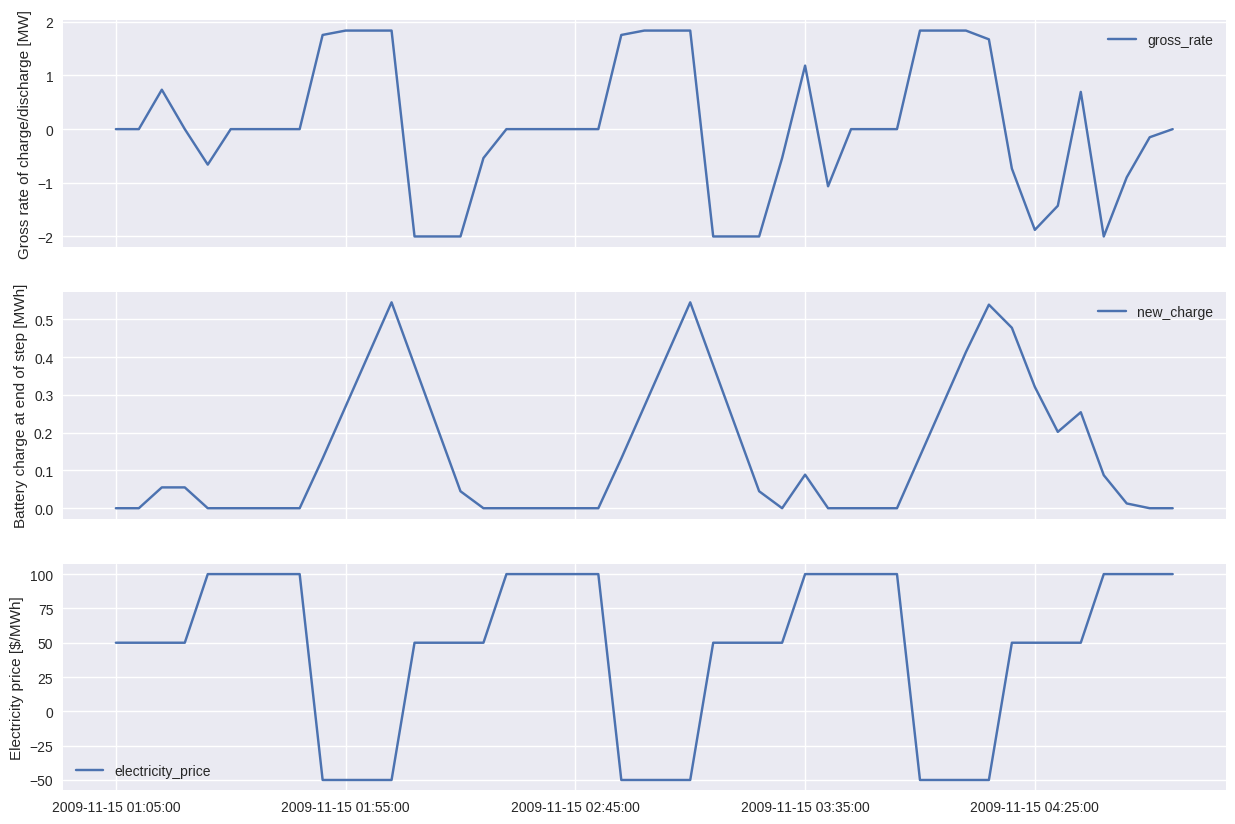

In [10]:
#  we can also take a look at a figure generated by the Battery env
#  showing the results of the last episode
#  1 - the gross rate of charge/discharge
#  2 - the charge level of the battery at the end of each step
#  3 - the electricity price
hist.figs_dict['env_panel_fig']

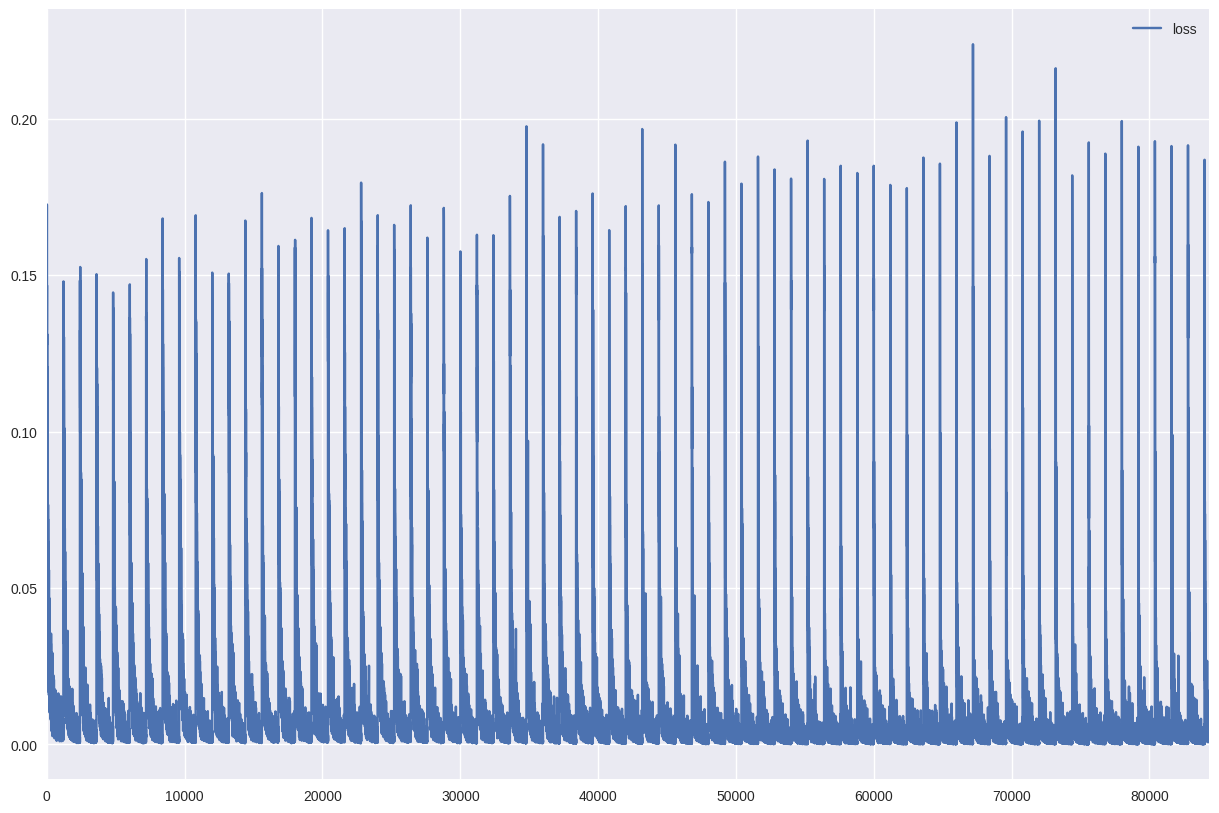

In [11]:
#  we can see from the loss function where we update the target 
#  network parameters, as the loss spikes up
hist.figs_dict['loss']

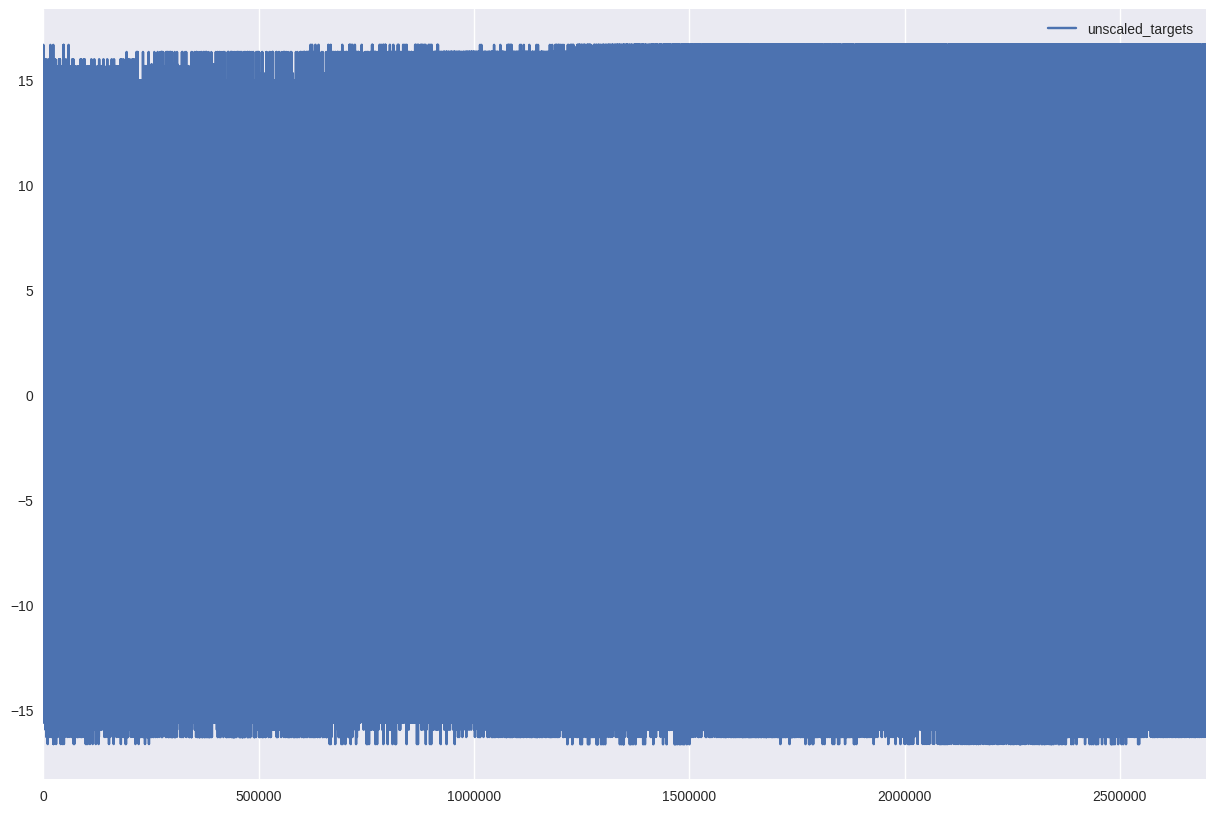

In [12]:
#  we can have a look at the unscaled training targets - note the range between +15 to -15
hist.figs_dict['unscaled_targets']

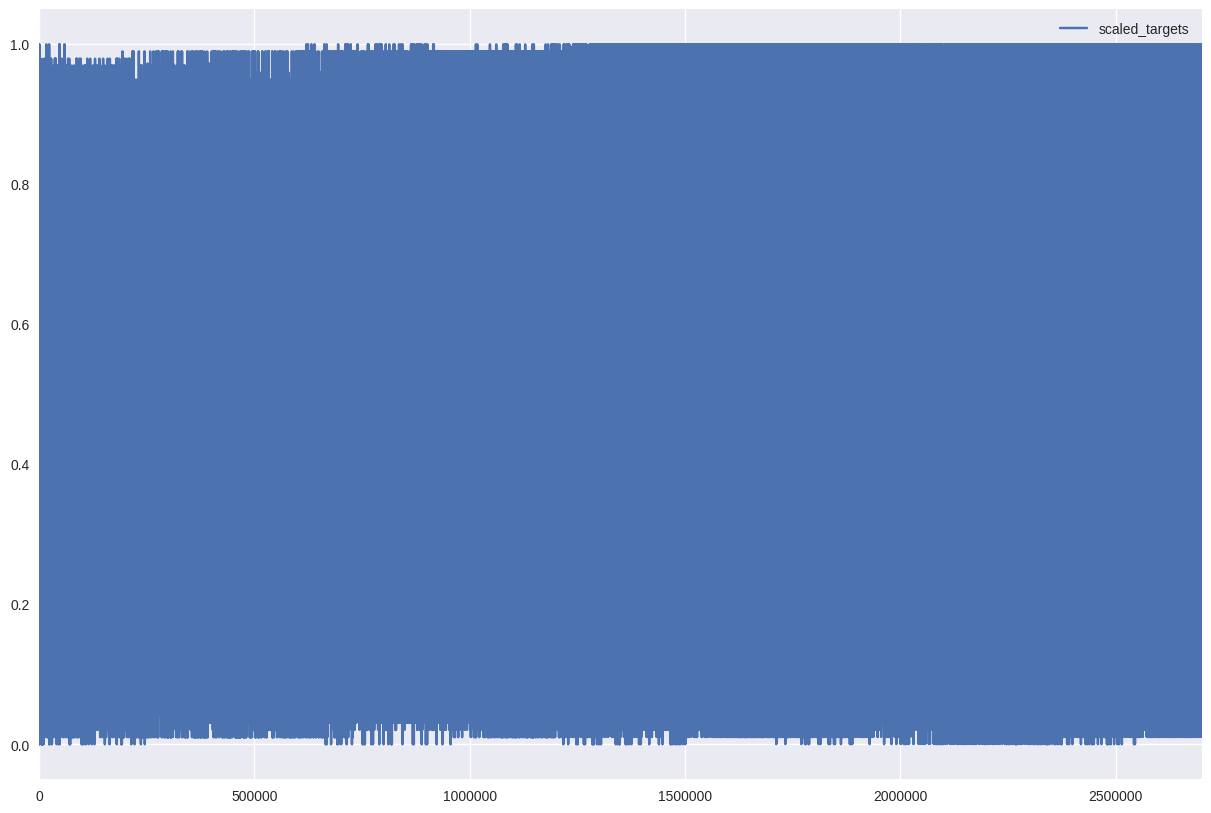

In [13]:
#  and also the scaled targets, which have been processed by the agent
#  using an energy_py Processor object - note the range between 0 and 1
hist.figs_dict['scaled_targets']

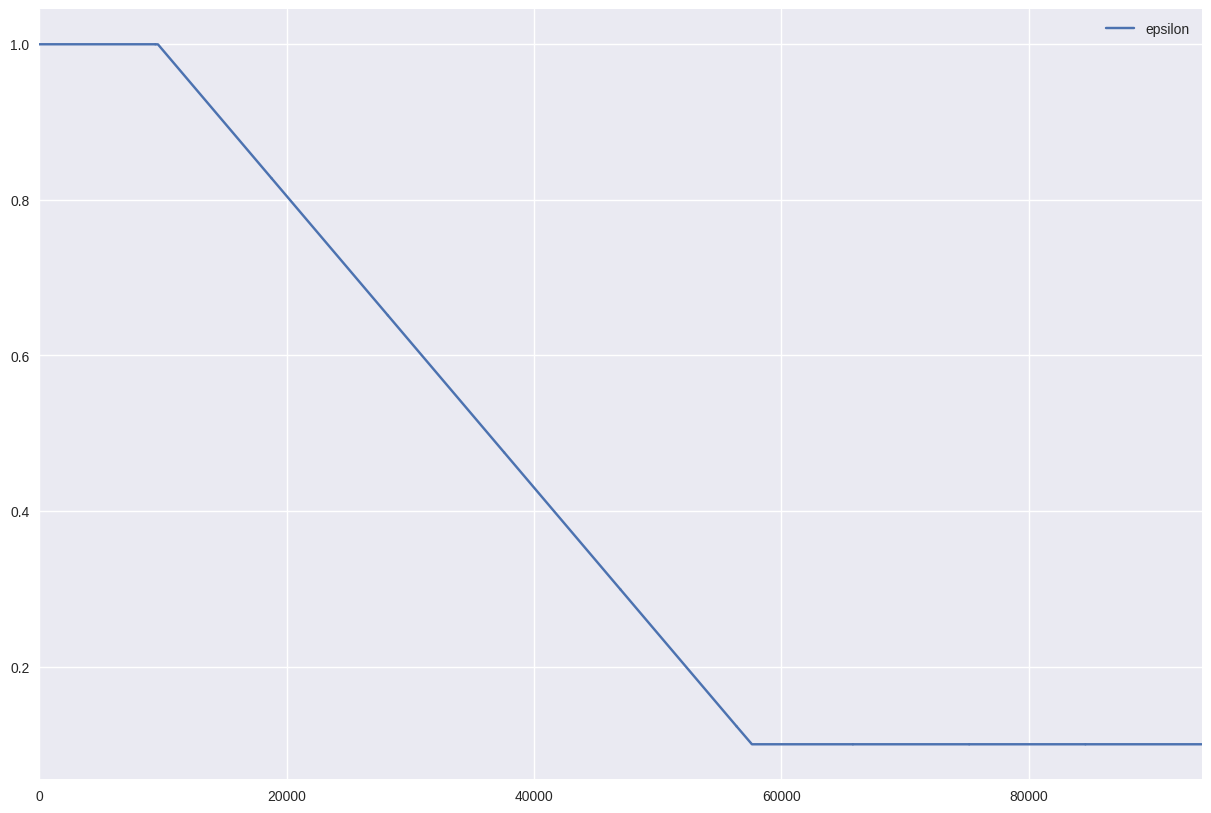

In [14]:
#  we can have a look at the epsilon decay schedule
hist.figs_dict['epsilon']